# Datalake using Geodes API

Datalake V2 data is accessible from CNES internal network through s3 protocol.

Datasets are referenced in the new portal https://geodes-portal.cnes.fr through a STAC API.

This API can be polled using several tools. We will see how to use some of them to search for Sentinel 2 L1C data and plot a NDVI on a given area from this data.

## EODAG with geodes_s3 data provider

### 1. Credentials configuration
``geodes_s3`` is the data provider pre-configured in [EODAG](https://github.com/CS-SI/eodag) v3.1.0 that will search data using  https://geodes-portal.cnes.fr STAC API and fetch Datalake s3 to list available data matching your search criteria.

First of all, we will [configure  EODAG](https://eodag.readthedocs.io/en/stable/getting_started_guide/configure.html) and set credentials for `geodes_s3` provider using [assumerole](https://gitlab.cnes.fr/hpc/softs/assumerole) library.

In the following example, we will get credentials for the role `public-read-only-OT`:

In [1]:
import os
from assumerole import assumerole

# public-read-only-OT role
arn = "arn:aws:iam::732885638740:role/public-read-only-OT"

# Set credentials for 1 hour, 60*60s
s3_credentials = assumerole.getCredentials(arn, 3600)
for k, v in s3_credentials.items():
    os.environ[f"EODAG__GEODES_S3__AUTH__CREDENTIALS__{k}"] = v

### 2. Search on Geodes

Then let's use EODAG to search for Sentinel 2 L1C products using `geodes_s3`provider

In [2]:
from eodag import EODataAccessGateway

dag = EODataAccessGateway()

In [3]:
search_criteria = {
    "geom": [1.435, 43.586, 1.458, 43.603],
    "start": "2023-07-01",
    "end": "2023-07-31",
    "cloudCover": 20,
}

prods = dag.search_all(provider="geodes_s3", productType="S2_MSI_L1C", **search_criteria)
prods = prods.filter_overlap(search_criteria["geom"], contains=True)
prods

SearchResult([EOProduct(id=S2B_MSIL1C_20230709T104629_N0509_R051_T31TCJ_20230709T125343, provider=geodes_s3),
              EOProduct(id=S2A_MSIL1C_20230714T105031_N0509_R051_T31TCJ_20230714T143218, provider=geodes_s3),
              EOProduct(id=S2B_MSIL1C_20230729T104629_N0509_R051_T31TCJ_20230729T125320, provider=geodes_s3)])

We will work on the first product returned in search results.

### 3. Lazy load as `xarray`

Filter keys of its assets having `"data"` in their roles, and get the data contained in the first one as `xarray.DataArray` using [EODAG-Cube](https://github.com/CS-SI/eodag-cube) `get_data()` method.

In [4]:
data_keys = [k for k, v in prods[0].assets.items() if "data" in v.get("roles", [])]
band = data_keys[0]
data_keys

['T31TCJ_20230709T104629_B08.jp2',
 'T31TCJ_20230709T104629_B06.jp2',
 'T31TCJ_20230709T104629_B01.jp2',
 'T31TCJ_20230709T104629_B10.jp2',
 'T31TCJ_20230709T104629_B8A.jp2',
 'T31TCJ_20230709T104629_B07.jp2',
 'T31TCJ_20230709T104629_B09.jp2',
 'T31TCJ_20230709T104629_B11.jp2',
 'T31TCJ_20230709T104629_B12.jp2',
 'T31TCJ_20230709T104629_B04.jp2',
 'T31TCJ_20230709T104629_B03.jp2',
 'T31TCJ_20230709T104629_TCI.jp2',
 'T31TCJ_20230709T104629_B02.jp2',
 'T31TCJ_20230709T104629_B05.jp2',
 'T31TCJ_20230709T104629_PVI.jp2']

In [5]:
prods[0].assets[band].get_data()

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
    spatial_ref  int64 8B 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

Note that without reworking the data like on this example, the `xarray.DataArray` will be lazy loaded.

`get_data()` accepts [rioxarray-open-rasterio()](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-open-rasterio) parameters as extra keyword-arguments. For example, get data in a **Dask Array** using default chunks:

In [6]:
prods[0].assets[band].get_data(chunks=True)

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
dask.array<open_rasterio-9082371e029f2cb0bb27ee1b54beec18<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
    spatial_ref  int64 8B 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### 4. Resample and recrop on the fly

In the following example, we want to get the data on a reduced extent and lower resolution, then use it to compute a NDVI.
Data will automatically be fetched using the given sampling criteria.

In [7]:
sampling_params = dict(
    crs="epsg:4326",                       # default projection
    resolution=0.0001,                     # but lower the resolution
    extent=(1.435, 43.586, 1.458, 43.603)  # zoom over/crop the area of interest
)

In [8]:
VIR_key = [k for k, v in prods[0].assets.items() if "data" in v.get("roles", []) and "_B04" in k][0]
NIR_key = [k for k, v in prods[0].assets.items() if "data" in v.get("roles", []) and "_B08" in k][0]

VIR = prods[0].assets[VIR_key].get_data(**sampling_params)
NIR = prods[0].assets[NIR_key].get_data(**sampling_params)

NDVI = (NIR - VIR * 1.0) / (NIR + VIR)
NDVI

<xarray.DataArray (band: 1, y: 170, x: 229)> Size: 311kB
array([[[-0.0341854 , -0.05103619,  0.0261259 , ...,  0.05340933,
          0.12683115,  0.34614065],
        [-0.03254068, -0.02250433,  0.05483745, ...,  0.0715039 ,
          0.11166151,  0.33825549],
        [-0.02726696, -0.00864969,  0.02885869, ...,  0.15199745,
          0.14528986,  0.29529494],
        ...,
        [ 0.04128761,  0.0302123 ,  0.07894388, ...,  0.18894671,
          0.18894671,  0.13441853],
        [-0.0591994 , -0.14064095, -0.17134779, ...,  0.1791518 ,
          0.1791518 ,  0.17885093],
        [-0.13148637, -0.13973102, -0.18094824, ...,  0.1907634 ,
          0.1907634 ,  0.18419062]]])
Coordinates:
  * x            (x) float64 2kB 1.435 1.435 1.435 1.435 ... 1.458 1.458 1.458
  * y            (y) float64 1kB 43.6 43.6 43.6 43.6 ... 43.59 43.59 43.59 43.59
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0

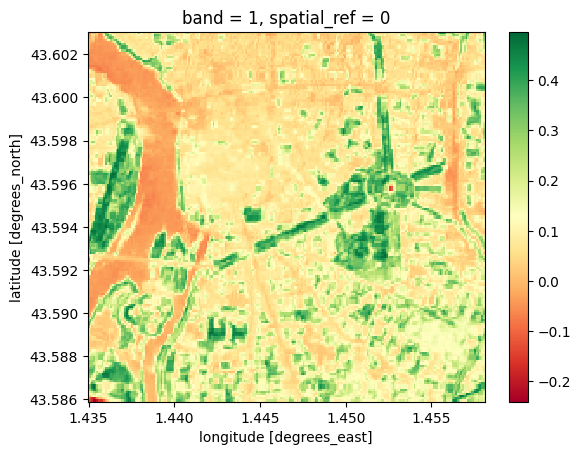

In [9]:
NDVI.plot(cmap="RdYlGn", center=False)